# Augment Visual Recognition Output with Tensorflow Object Detection


## 1. Setup

To prepare your environment, you need to install some packages and enter credentials for the Watson services.

## 1.1 Install the necessary packages

### Install Watson Developer Cloud Package

In [1]:
!pip install --upgrade "watson-developer-cloud>=2.1.1"

Requirement already up-to-date: watson-developer-cloud>=2.1.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: python-dateutil>=2.5.3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud>=2.1.1)
Requirement not upgraded as not directly required: websocket-client==0.47.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud>=2.1.1)
Requirement not upgraded as not directly required: requests<3.0,>=2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud>=2.1.1)
Requirement not upgraded as not directly required: six>=1.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from python-dateutil>=2.5.3->watson-developer-cloud>=2.1.1)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.0->watson-developer-cloud>=2.1

### Install Tensorflow 1.9 package 
Tensorflow 1.9 is required for the Object Detection API

In [2]:
!pip install tensorflow==1.9 --force-reinstall

Requirement not upgraded as not directly required: tensorflow==1.9 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: wheel>=0.26 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from tensorflow==1.9)
Requirement not upgraded as not directly required: gast>=0.2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from tensorflow==1.9)
Requirement not upgraded as not directly required: grpcio>=1.8.6 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from tensorflow==1.9)
Requirement not upgraded as not directly required: numpy>=1.13.3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from tensorflow==1.9)
Requirement not upgraded as not directly required: six>=1.10.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from tensorflow==1.9)
Requirement not upgraded as not directly required: protobuf>=3.4.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from tensor

### Install Protobuf version 3.6

Protobuf version 3.6.0 is required for the Object Deetection API

In [3]:
!pip install protobuf==3.6 --force-reinstall

Requirement not upgraded as not directly required: protobuf==3.6 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: six>=1.9 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from protobuf==3.6)
Requirement not upgraded as not directly required: setuptools in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from protobuf==3.6)


### Now restart the kernel by choosing Kernel > Restart.

## 2. Configuration

Add configurable items of the notebook below

## 2.1 Add your service credentials for Object Storage

You must create Object Storage service on IBM Cloud. To access data in a file in Object Storage, you need the Object Storage authentication credentials. Insert the Object Storage Streaming Body credentials and ensure the variable is referred as streaming_body_1 in the following cell after removing the current contents in the cell.

### 2.2 Extract the Files

Input the zip file from object storage and extract the Object Detection Models onto the /home/spark/shared folder

In [2]:
from io import BytesIO
import zipfile

zip_ref = zipfile.ZipFile(BytesIO(streaming_body_1.read()),'r')
paths = zip_ref.namelist()
classes_required=[]
for path in paths:
    zip_ref.extract(path)  

### 2.3 Object Detetcion Environment Setup

The Tensorflow Object Detection API uses Protobufs to configure model and training parameters. The below statements needs to compile the Protobuf

In [3]:
!protoc object_detection/protos/*.proto --python_out=.

### 2.4 Import packages and libraries

Import the packages and libraries that you'll use:

In [4]:
from distutils.version import StrictVersion
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import json

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from watson_developer_cloud import VisualRecognitionV3
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


### Object detection imports

Setup matplotlib environment.
Here are the imports from the object detection module.

In [5]:
%matplotlib inline

In [6]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/home/dsxuser/work/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/envs/DSX-Python35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/DSX-Python35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/kernelapp.py"

## 3. Model Configuration

### 3.1 Set up Model Parameters

In [7]:
# What model to download.

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = 'object_detection/Model/frozen_inference_graph.pb'

# Label of the Input Image

label='Covered'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS ='object_detection/object-detection.pbtxt'

NUM_CLASSES = 1

### 3.2 Load a (frozen) Tensorflow model into memory.

In [8]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### 3.3 Loading label map

In [9]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

### 3.4 Setup Images

In [10]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    if image.format == 'PNG':
        image = image.convert('RGB')
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# 4. Covered Face Detection

## 4.1 Import Test Images


In [11]:
# For the sake of simplicity we will use only 5 images:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'object_detection/Data/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, label+'{}.jpg'.format(i)) for i in range(1, 5) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

## 4.2 Covered Face Tensorflow Object Detection 

Below functions perform Object Detection on Input Test Image

In [12]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
          # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

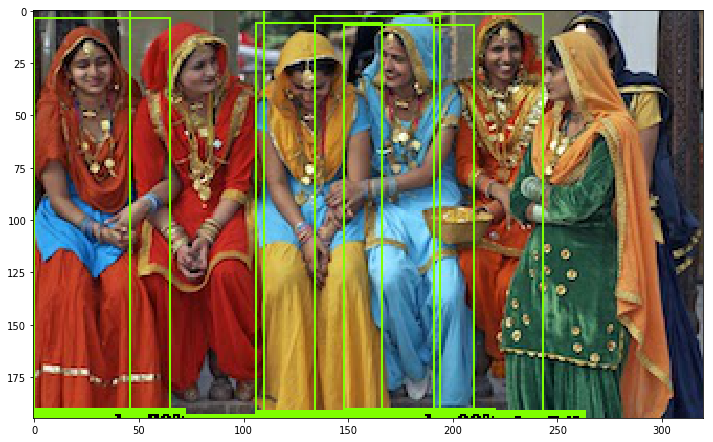

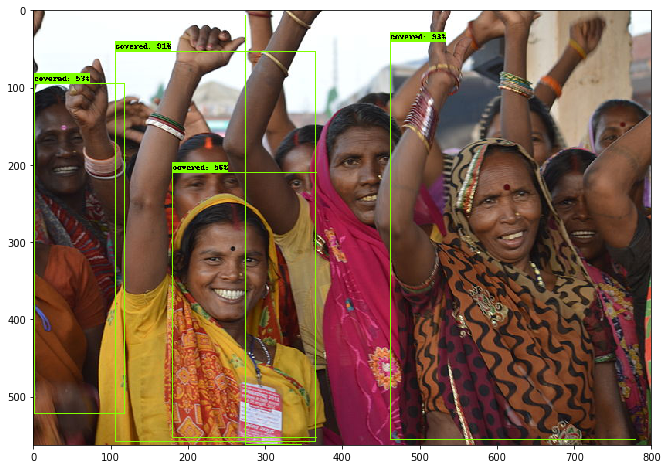

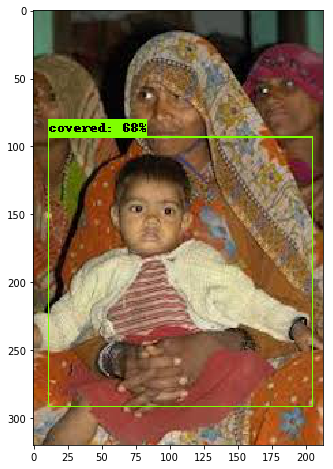

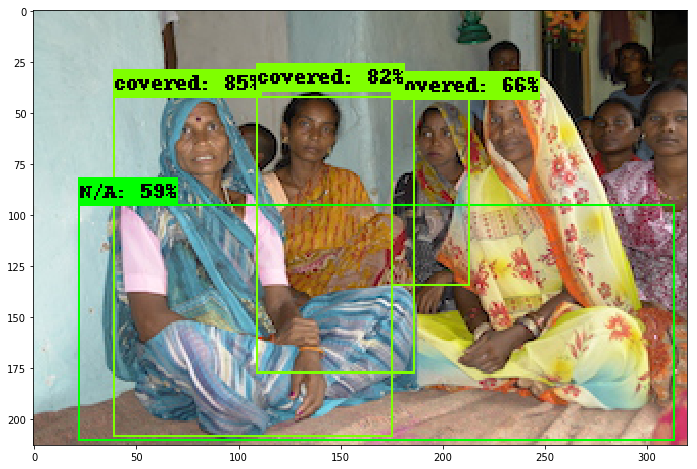

In [14]:
ctr=0
for image_path in TEST_IMAGE_PATHS:
    ctr=ctr+1
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=1)
    output_path="./object_detection/Output_Images/"
    image_name="Output"+str(ctr)+".jpg"
    #print(output_dict['detection_boxes'])
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.savefig(output_path+image_name)

## 4.3 Augment Object Detection output to Watson Visual Recognition Output

4


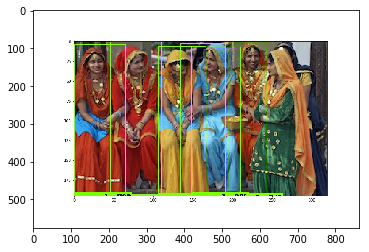

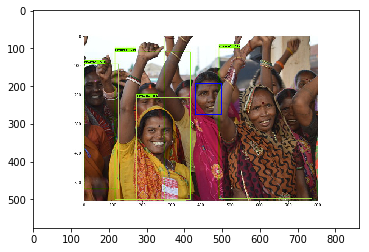

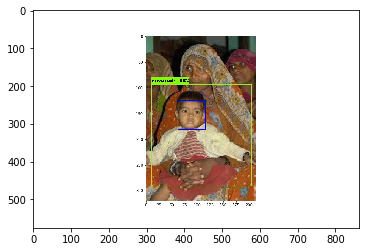

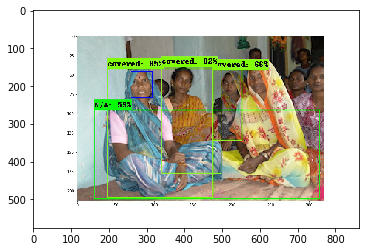

In [16]:
PATH_TO_OUTPUT_IMAGES_DIR = './object_detection/Output_Images/'
OUTPUT_IMAGE_PATHS = [ os.path.join(PATH_TO_OUTPUT_IMAGES_DIR, 'Output{}.jpg'.format(i)) for i in range(1, 5) ]

print(len(OUTPUT_IMAGE_PATHS))
FINAL_OUTPUT='./Final_Output/'
for o in OUTPUT_IMAGE_PATHS:
    visual_recognition = VisualRecognitionV3(
        '2018-03-19',
        iam_apikey='')

    with open(o, 'rb') as images_file:
        faces = json.loads(str(visual_recognition.detect_faces(images_file)))
    im = Image.open(o)
    if len(faces['result']['images'][0]['faces']) !=0:
        ymax_v=faces['result']['images'][0]['faces'][0]['face_location']['height']
        xmax_v=faces['result']['images'][0]['faces'][0]['face_location']['width']
        xmin_v=faces['result']['images'][0]['faces'][0]['face_location']['left']
        ymin_v=faces['result']['images'][0]['faces'][0]['face_location']['top']

        (left_v, right_v, top_v, bottom_v) = (xmin_v, xmax_v+xmin_v, ymin_v, ymax_v+ymin_v)
        draw = ImageDraw.Draw(im)
        draw.line([(left_v, top_v), (left_v, bottom_v), (right_v, bottom_v),(right_v, top_v), (left_v, top_v)], width=2, fill='blue')
    plt.figure()
    plt.imshow(np.asarray(im))
